## Packages

In [1]:
# to speed-up execution, mark this as True
USE_CACHED_RESULTS=False
# cross-fold crashes Github CI
USE_CACHED_CV5_RESULTS = True

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import maxent
import maxentep as py0
import tensorflow as tf
tf.get_logger().setLevel('INFO')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyabc
import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')

## Set-up SEAIR Model

In [3]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)

[4241. 3868. 1023.] [144101. 110004. 124468.]


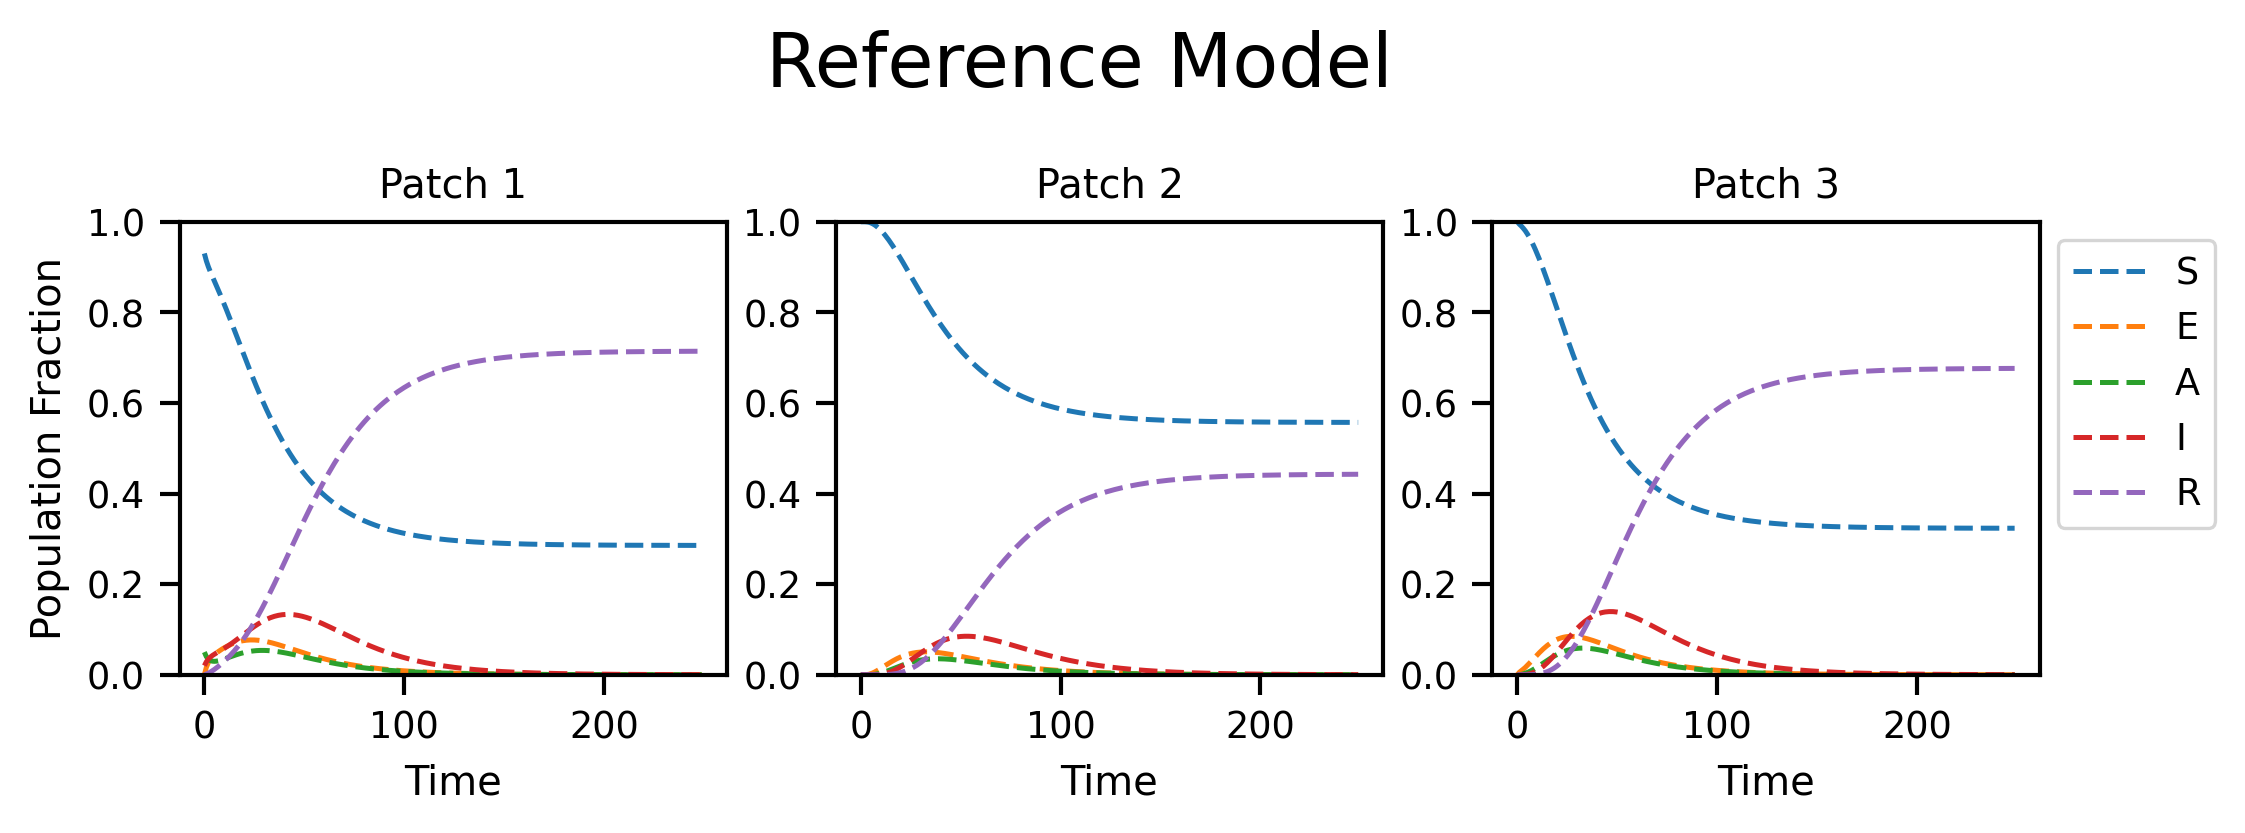

In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
infect_fxn = py0.contact_infection_func(infections_compartments)
full_compartments = ['S'] + compartments
R = np.array([[1000, 400, 10],
         [0, 300, 300],
         [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    timesteps = 250
    meta_model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
ref_inpputs = [0.02, 0.05, 7, 5, 14]
ref_traj = metapop_wraper(*ref_inpputs )
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--', label=full_compartments)
axs[0].set_ylabel('Population Fraction')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [5]:
npoints = 5
np.random.seed(0)
prior = maxent.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300826 0.10784731813725082
45 0.13207552 0.1526054434665933
31 0.12169184 0.12889401646488136
80 0.06942835 0.1421420223992924
17 0.08018874 0.11824062257689161


## Sample SEAIR Trajectories

In [6]:
tf.random.set_seed(0)
if not USE_CACHED_RESULTS or not os.path.exists('epidemiology_files/maxent_sample_trajs'):
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1)
    tmat.add_transition('A', 'I', 2, 4)
    tmat.add_transition('I', 'R', 10, 5)
    start_logits = np.zeros((M))
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_var = 0.00001
    hyper_pram.beta_start = 0.025
    hyper_pram.beta_high = 0.02502
    hyper_pram.beta_low = 0.02501
    hyper_pram.start_mean = 0.001
    hyper_pram.start_high = 0.4
    hyper_pram.start_var = 0.8
    hyper_pram.R_var = 0.00001
    param_model = py0.MetaParameterJoint(start_logits, R, tmat, name='unbiased model', hypers = hyper_pram)
    # Fxing beta and mobility matrix
    R_norm_sample = tf.convert_to_tensor(R_norm)
    beta_sample = tf.convert_to_tensor([0.025])
    N = 2048
    batches = 4
    batch_size = N*batches
    outs = []
    timesteps = 250
    model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    for b in tqdm.tqdm(range(batches)):
        psample = param_model.sample(N)
        outs.append(model(*psample))
    trajs = np.concatenate(outs, axis=0)
    np.save('epidemiology_files/maxent_sample_trajs', trajs)
else:
    trajs = np.load('epidemiology_files/maxent_sample_trajs.npy')


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.55s/it]


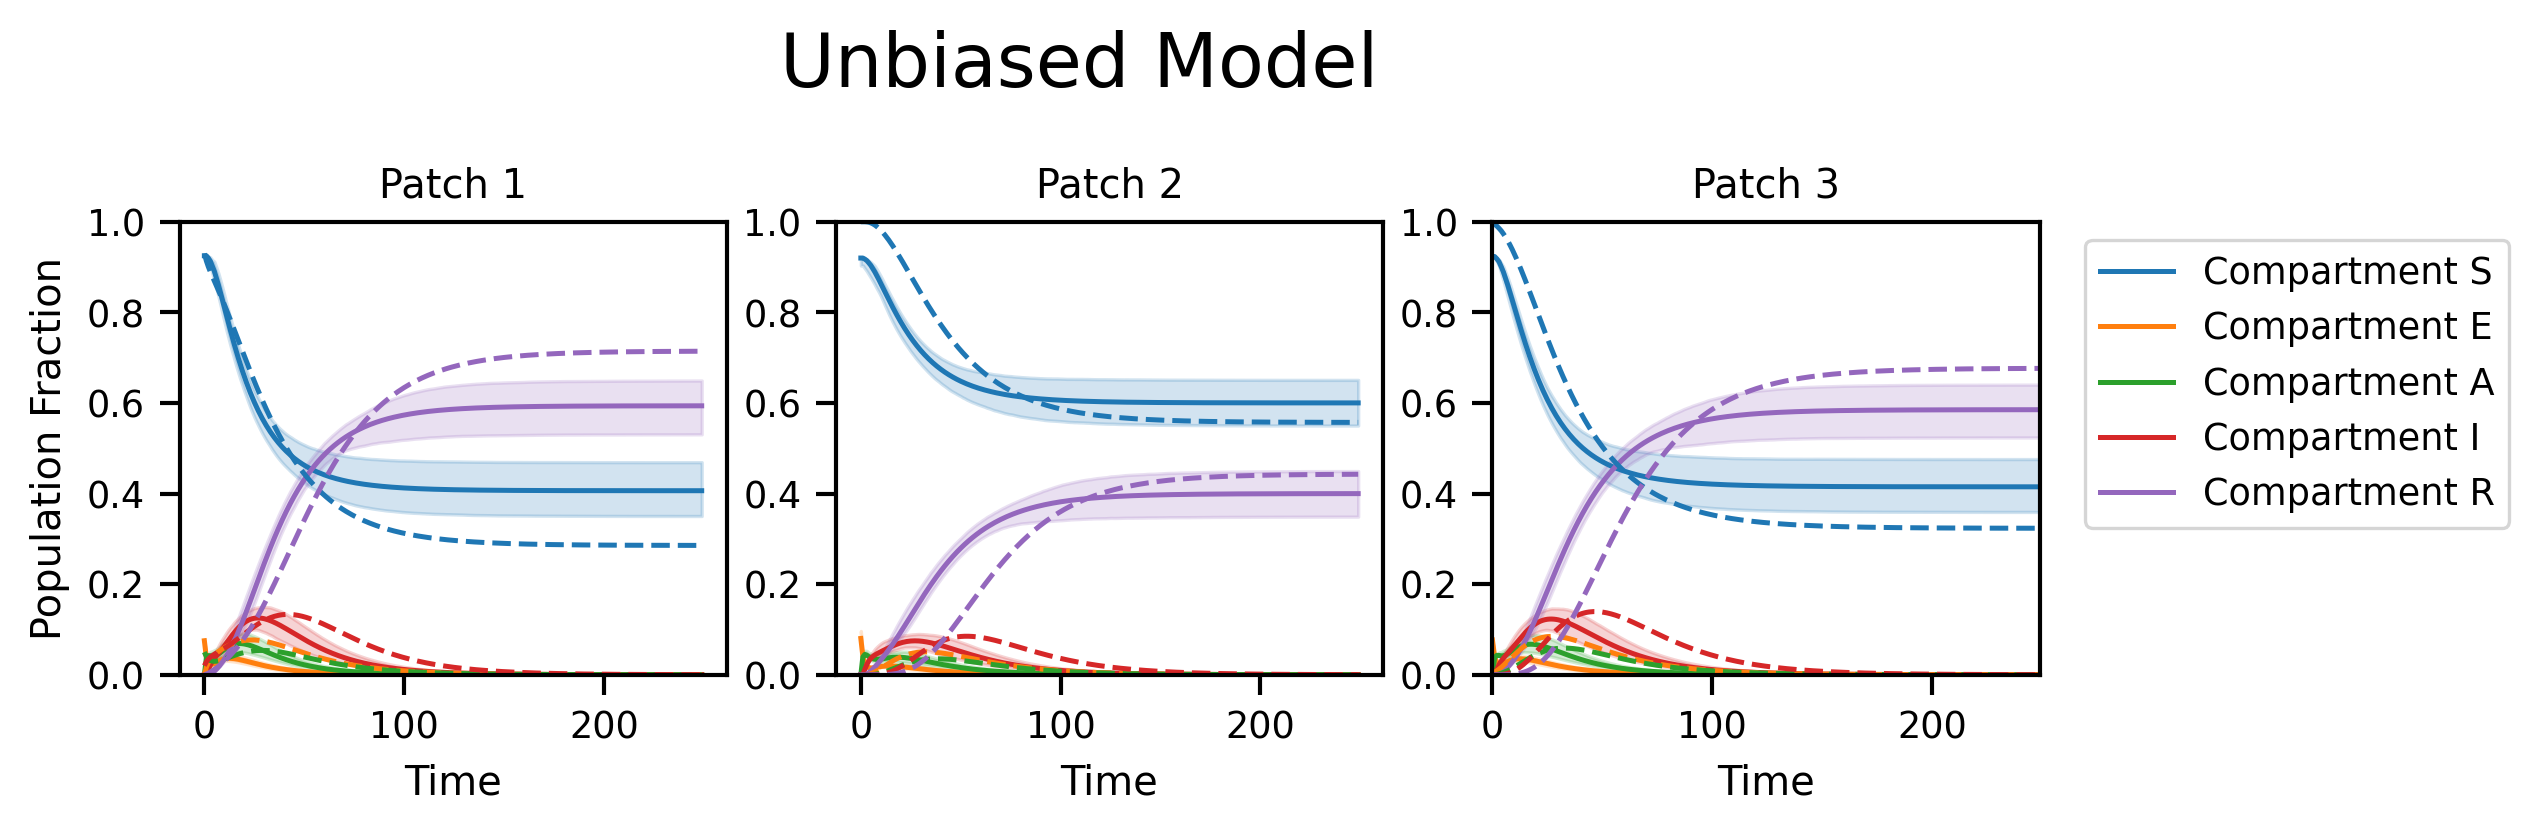

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

In [8]:
if not USE_CACHED_RESULTS:
    me_model = maxent.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)
    me_w = me_model.traj_weights
    np.save('epidemiology_files/maxent_biased_me_w', me_w)
else:
    me_w = np.load('epidemiology_files/maxent_biased_me_w.npy')

Epoch 1/1000
1/1 [==============================] - 1s 752ms/step - loss: 0.0043 - weight-entropy: 9.0092
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 9.0100
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 9.0104
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 9.0099
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 9.0089
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0038 - weight-entropy: 9.0074
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 9.0055
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 9.0030
Epoch 10/1000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4872
Epoch 80/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4840
Epoch 81/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4810
Epoch 82/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4780
Epoch 83/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4752
Epoch 84/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4724
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4697
Epoch 86/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4671
Epoch 87/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4646
Epoch 88/1000
1/1 [==============================] - 0s 2ms/step - lo

1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 8.3678
Epoch 157/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 8.3667
Epoch 158/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3657
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3646
Epoch 160/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3636
Epoch 161/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 8.3625
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3615
Epoch 163/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3604
Epoch 164/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3594
Epoch 165/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2948
Epoch 234/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2939
Epoch 235/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2931
Epoch 236/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2922
Epoch 237/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2914
Epoch 238/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2905
Epoch 239/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2896
Epoch 240/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2888
Epoch 241/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2879
Epoch 242/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2324
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2317
Epoch 312/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2309
Epoch 313/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2301
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2294
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2286
Epoch 316/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2279
Epoch 317/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2271
Epoch 318/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2264
Epoch 319/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1772
Epoch 388/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1765
Epoch 389/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1758
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1751
Epoch 391/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1745
Epoch 392/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1738
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1731
Epoch 394/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1725
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1718
Epoch 396/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1281
Epoch 465/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1275
Epoch 466/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1269
Epoch 467/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1263
Epoch 468/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1257
Epoch 469/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1251
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1245
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1239
Epoch 472/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1233
Epoch 473/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0831
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0825
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0819
Epoch 544/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0814
Epoch 545/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0808
Epoch 546/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0802
Epoch 547/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.0796
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0790
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0785
Epoch 550/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0366
Epoch 619/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0360
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0353
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0347
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0340
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0333
Epoch 624/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0327
Epoch 625/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 8.0320
Epoch 626/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0313
Epoch 627/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9784
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9776
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9767
Epoch 698/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9758
Epoch 699/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9749
Epoch 700/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9740
Epoch 701/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9731
Epoch 702/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9722
Epoch 703/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9712
Epoch 704/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.8973
Epoch 773/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8960
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.8948
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.8935
Epoch 776/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 7.8923
Epoch 777/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8910
Epoch 778/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.8898
Epoch 779/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8885
Epoch 780/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8872
Epoch 781/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7873
Epoch 850/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 7.7857
Epoch 851/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 7.7841
Epoch 852/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7825
Epoch 853/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7808
Epoch 854/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7792
Epoch 855/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7775
Epoch 856/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7759
Epoch 857/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7742
Epoch 858/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 3ms/step - loss: 9.4810e-04 - weight-entropy: 7.6533
Epoch 925/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4697e-04 - weight-entropy: 7.6514
Epoch 926/1000
1/1 [==============================] - 0s 2ms/step - loss: 9.4584e-04 - weight-entropy: 7.6495
Epoch 927/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.4473e-04 - weight-entropy: 7.6475
Epoch 928/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4360e-04 - weight-entropy: 7.6455
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4247e-04 - weight-entropy: 7.6436
Epoch 930/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4136e-04 - weight-entropy: 7.6416
Epoch 931/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4023e-04 - weight-entropy: 7.6396
Epoch 932/1000
1/1 [==============================] - 0s 2ms/step - loss: 9.3912e-04 - weight-entropy: 7.6377
Epoch 933/1000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 8.6806e-04 - weight-entropy: 7.5003
Epoch 999/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.6703e-04 - weight-entropy: 7.4982
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.6600e-04 - weight-entropy: 7.4960


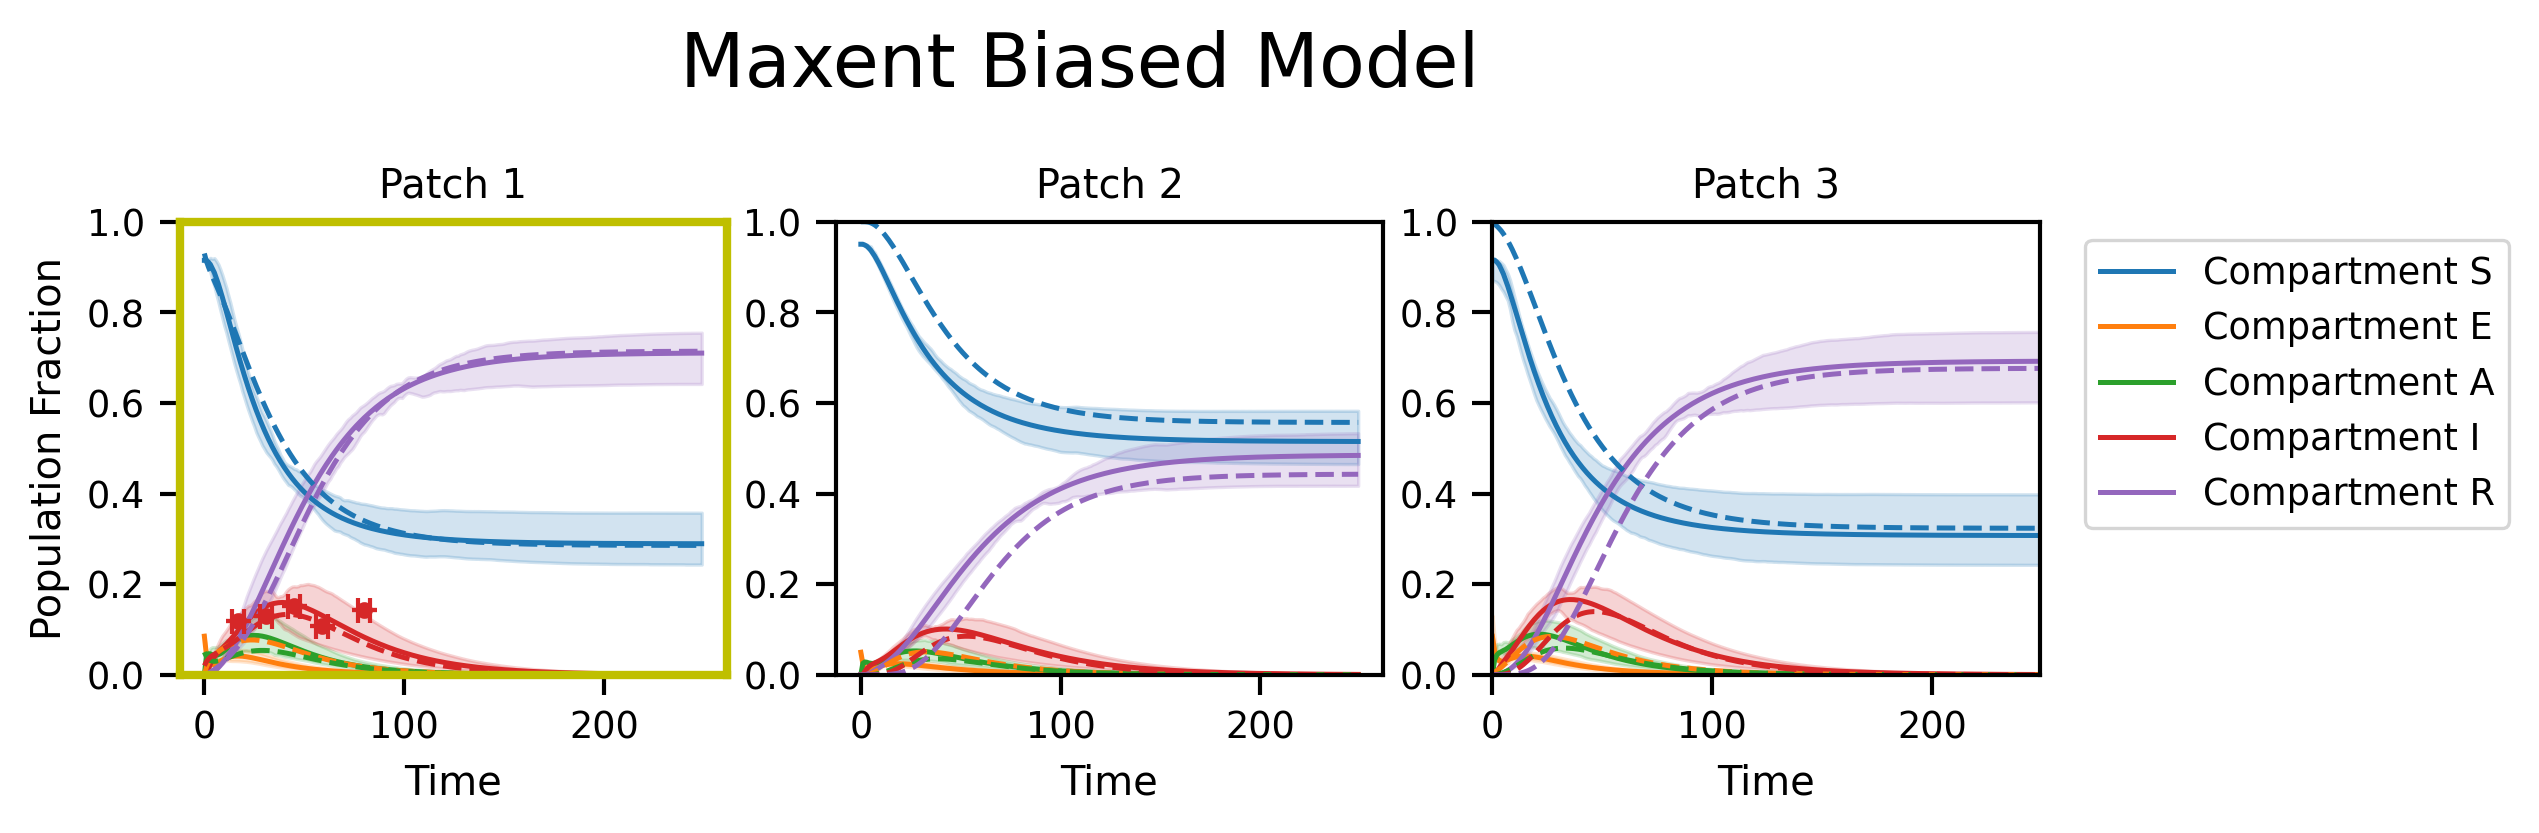

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [10]:
if not USE_CACHED_RESULTS:
    C = len(compartments)
    start = np.zeros((M, C))
    start[0,1] = 0.001
    start[0,2] = 0.001
    beta_start = 0.1
    infect = py0.ContactInfectionLayer(beta_start, infections_compartments)
    # make "agreement" function
    def agreement(traj, rs=restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, agreement)
    rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj = rmodel.get_traj()
    rmodel.fit(timesteps)
    regressed_traj = rmodel.get_traj()
    np.save('epidemiology_files/ls_biased_traj', regressed_traj)
else:
    regressed_traj = np.load('epidemiology_files/ls_biased_traj.npy')

250/250 [==============================] - 10s 36ms/step - loss: 0.0055 - output_2_loss: 0.0055


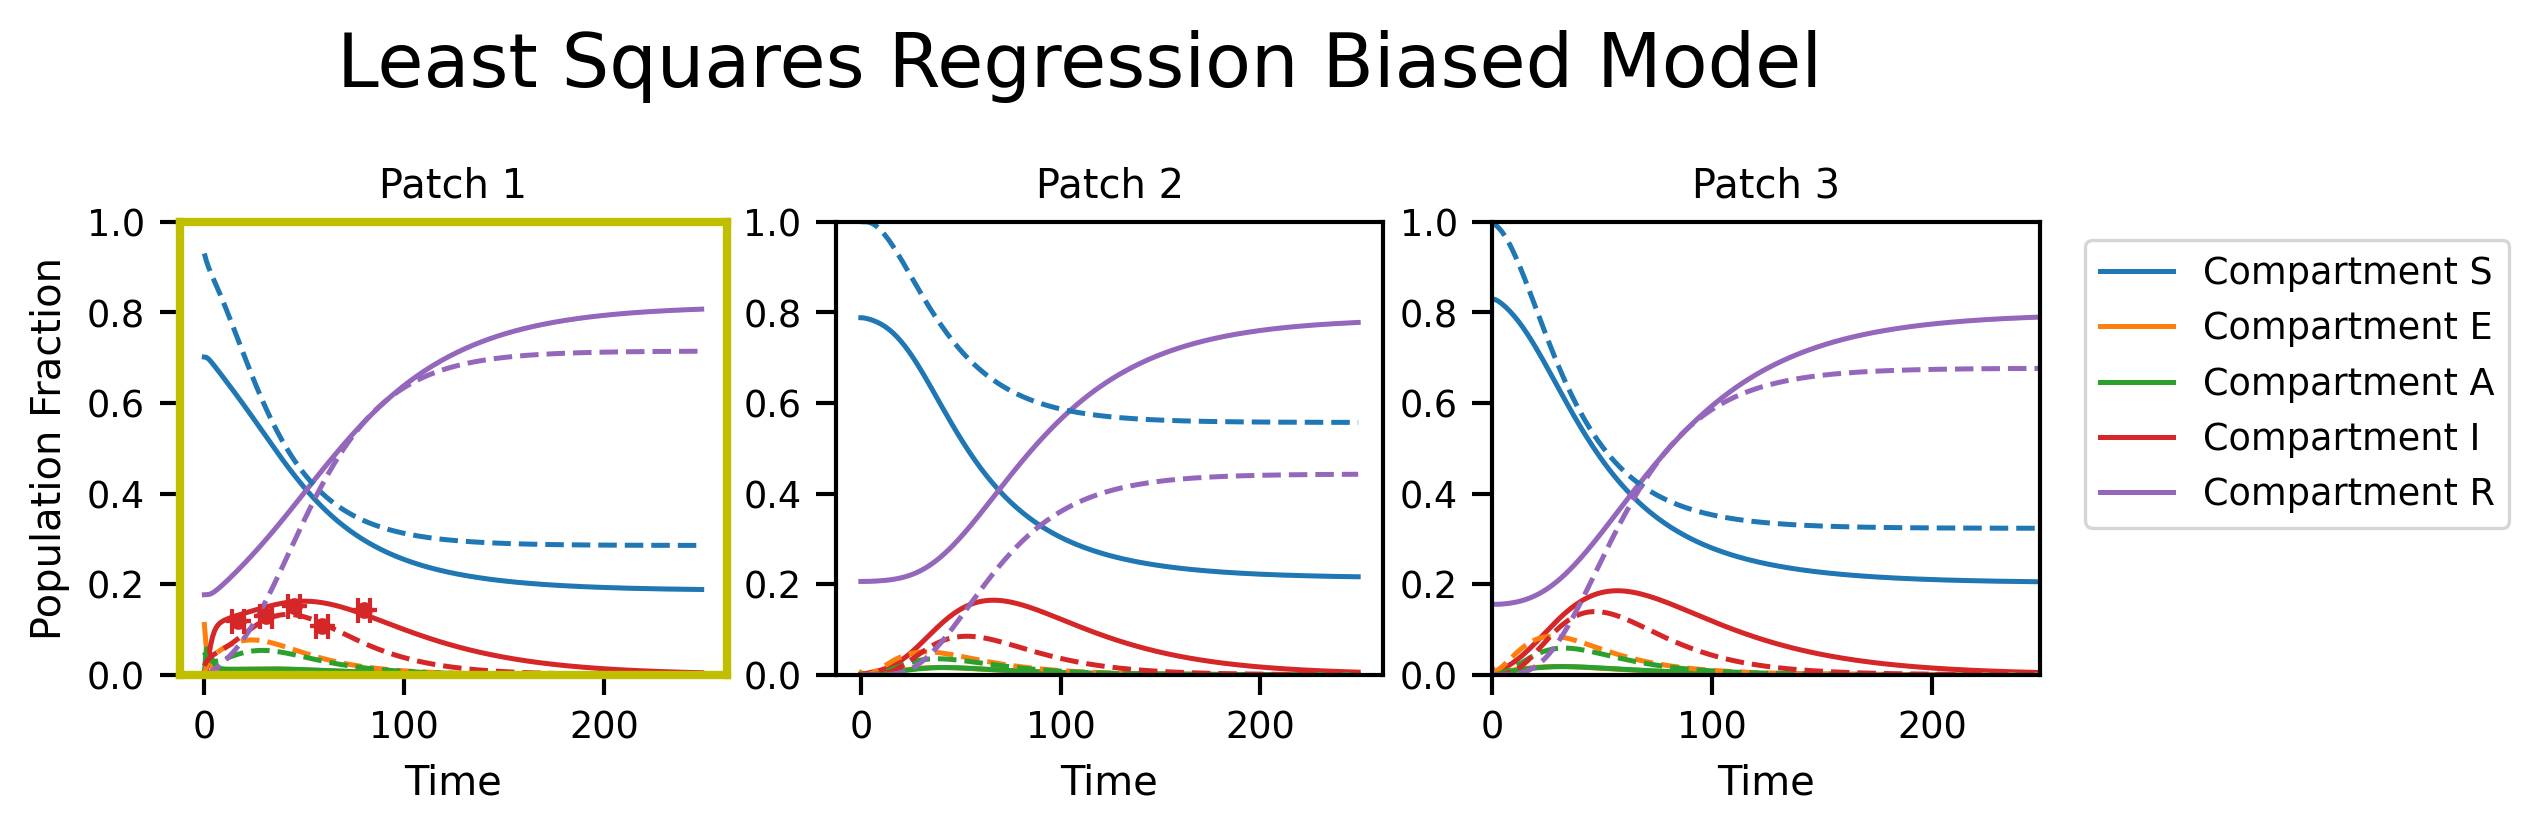

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regression Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## abc

In [16]:
np.random.seed(0)
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10
abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def abc_model(parameter):
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
if not USE_CACHED_RESULTS:
    parameter_priors = pyabc.Distribution(
                                    start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                    start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                    E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                    A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                    I_time=pyabc.RV('norm', abc_param_values[4], 5))

    abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db') 
    observation = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation})
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    df, w_abc = history.get_distribution(m=0, t=history.max_t)
    abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
    for i, row in enumerate(tqdm.tqdm(np.array(df))):
        A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
        traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
        abc_trajs[i] = traj
    abc_biased_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
    np.save('epidemiology_files/abc_biased_traj.npy', abc_biased_traj)
else:
    abc_biased_traj = np.load('epidemiology_files/abc_biased_traj.npy')

INFO:Sampler:Parallelizing the sampling on 16 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4947641586901674
INFO:ABC:t: 0, eps: 0.4947641586901674.
INFO:ABC:Acceptance rate: 100 / 219 = 4.5662e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38435913315826437.
INFO:ABC:Acceptance rate: 100 / 239 = 4.1841e-01, ESS=6.2138e+01.
INFO:ABC:t: 2, eps: 0.3287198206807549.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=5.5395e+01.
INFO:ABC:t: 3, eps: 0.2875645439526921.
INFO:ABC:Acceptance rate: 100 / 240 = 4.1667e-01, ESS=5.6249e+01.
INFO:ABC:t: 4, eps: 0.24658838319088924.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=4.2200e+01.
INFO:History:Done <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=2021-08-03 20:28:56.873078)>
100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


## 5-fold cross validation

In [ ]:
if not USE_CACHED_CV5_RESULTS:
    LS_traj_folds = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
    MaxEnt_traj_folds = np.empty_like(LS_traj_folds)
    abc_traj_folds = []
    for i in range(npoints):
        sampled_restraints = [n for n in restraints if n != restraints[i]]
        ## MaxEnt
        print(f'Initializing LS for fold {i}')
        def new_agreement(traj, rs=sampled_restraints):
            s = 0
            for r in rs:
                s += r(traj[0])**2
            return s
        rmodel_sampled = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, new_agreement)
        rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
        utraj_sampled = rmodel_sampled.get_traj()
        rmodel_sampled.fit(timesteps)
        regressed_traj_sampled = rmodel_sampled.get_traj()
        LS_traj_folds[i,:,:,:] = regressed_traj_sampled
        ## MaxEnt
        print(f'Initializing MaxEnt for fold {i}')
        me_model_sample = py0.MaxentModel(sampled_restraints, trajs=trajs, population_fraction=population_fraction)
        me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
        me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size, epochs=1000)
        MaxEnt_traj_folds[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        ## ABC
        print(f'Initializing ABC for fold {i}')
        def abc_model(parameter):
            trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']),
                                        + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time']))
            restrainted_time_values = [59, 45, 31, 80, 17]
            restrainted_time_values.pop(i)
            values = np.array([trajectory[m, 0, 3].numpy()
                               for m in restrainted_time_values])
            return {'data': values}
        parameter_priors = pyabc.Distribution(
                                        start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                        start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                        E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                        A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                        I_time=pyabc.RV('norm', abc_param_values[4], 5))

        abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
        db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db')
        observation_abc = np.array([r.target for r in sampled_restraints])
        abc.new(db_path, {'data': observation_abc})
        history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
        df, w_abc = history.get_distribution(m=0, t=history.max_t)
        abc_trajs = np.empty(
            (len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
        for j, row in enumerate(tqdm.tqdm(np.array(df))):
            A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc = row[
                0], row[1], row[2], row[3], row[4]
            traj = metapop_wraper(
                abs(start_infected_abc), abs(start_asymptomatic_abc), E_time_abc, A_time_abc, I_time_abc)
            abc_trajs[j] = traj
        mean_abc_traj = np.sum(
                abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        abc_traj_folds.append(mean_abc_traj)
    np.save('epidemiology_files/abc_traj_folds.npy', abc_traj_folds)
    np.save('epidemiology_files/MaxEnt_traj_folds.npy', MaxEnt_traj_folds)
    np.save('epidemiology_files/LS_traj_folds.npy', LS_traj_folds)
abc_traj_folds = np.load('epidemiology_files/abc_traj_folds.npy')
MaxEnt_traj_folds = np.load('epidemiology_files/MaxEnt_traj_folds.npy')
LS_traj_folds = np.load('epidemiology_files/LS_traj_folds.npy')

In [ ]:
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_traj_folds)
std_MaxEnt = find_std(MaxEnt_traj_folds)
std_LS = find_std(LS_traj_folds)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)


In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None,
                       values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(trajs * me_w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
qtrajs_maxentbiased = np.apply_along_axis(lambda x: weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_w), 0, trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)

axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_biased_traj[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])


# Variational Inference

In [28]:
fit_param_model = py0.MetaParameterJoint(start_logits, R, tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [29]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=5, param_epochs=500, batch_size=batch_size//4, epochs=1000, verbose=0)

Epoch 1/500
64/64 [==============================] - 4s 1ms/step - loss: 58660980.0000 - R-dist-dist_loss: 58660980.0000 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9147e-04 - beta-dist_loss: -0.2358
Epoch 2/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2347 - R-dist-dist_loss: 0.0027 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9375e-04 - beta-dist_loss: -0.2358
Epoch 3/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2348 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9225e-04 - beta-dist_loss: -0.2358
Epoch 4/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2349 - R-dist-dist_loss: 0.0026 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9377e-04 - beta-dist_loss: -0.2358
Epoch 5/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2350 - R-dist-dist_loss: 0.0025 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9063e-04 - beta-dist_loss: -0.2358
Epoch 6

64/64 [==============================] - 0s 1ms/step - loss: -0.2342 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9280e-04 - beta-dist_loss: -0.2358
Epoch 43/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2342 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9336e-04 - beta-dist_loss: -0.2358
Epoch 44/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2342 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9217e-04 - beta-dist_loss: -0.2358
Epoch 45/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2342 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9284e-04 - beta-dist_loss: -0.2358
Epoch 46/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2342 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9342e-04 - beta-dist_loss: -0.2358
Epoch 47/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9333e-04 - beta-dist_loss: -0.2358
Epoch 84/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9256e-04 - beta-dist_loss: -0.2358
Epoch 85/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9166e-04 - beta-dist_loss: -0.2358
Epoch 86/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9374e-04 - beta-dist_loss: -0.2358
Epoch 87/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9283e-04 - beta-dist_loss: -0.2358
Epoch 88/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9182e-04 - beta-dist_loss: -0.2358
Epoch 125/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9197e-04 - beta-dist_loss: -0.2358
Epoch 126/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9241e-04 - beta-dist_loss: -0.2358
Epoch 127/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9214e-04 - beta-dist_loss: -0.2358
Epoch 128/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9298e-04 - beta-dist_loss: -0.2358
Epoch 129/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9321e-04 - beta-dist_loss: -0.2358
Epoch 166/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9147e-04 - beta-dist_loss: -0.2358
Epoch 167/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9412e-04 - beta-dist_loss: -0.2358
Epoch 168/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9199e-04 - beta-dist_loss: -0.2358
Epoch 169/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9076e-04 - beta-dist_loss: -0.2358
Epoch 170/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0037 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.8786e-04 - beta-dist_loss: -0.2358
Epoch 207/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2338 - R-dist-dist_loss: 0.0037 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9078e-04 - beta-dist_loss: -0.2358
Epoch 208/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2338 - R-dist-dist_loss: 0.0036 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9332e-04 - beta-dist_loss: -0.2358
Epoch 209/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2339 - R-dist-dist_loss: 0.0035 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9451e-04 - beta-dist_loss: -0.2358
Epoch 210/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2341 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9097e-04 - beta-dist_loss: -0.2358
Epoch 211/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9320e-04 - beta-dist_loss: -0.2358
Epoch 248/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9404e-04 - beta-dist_loss: -0.2358
Epoch 249/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9129e-04 - beta-dist_loss: -0.2358
Epoch 250/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9285e-04 - beta-dist_loss: -0.2358
Epoch 251/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0044 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9381e-04 - beta-dist_loss: -0.2358
Epoch 252/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.8979e-04 - beta-dist_loss: -0.2358
Epoch 289/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9040e-04 - beta-dist_loss: -0.2358
Epoch 290/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9444e-04 - beta-dist_loss: -0.2358
Epoch 291/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9095e-04 - beta-dist_loss: -0.2358
Epoch 292/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0043 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9351e-04 - beta-dist_loss: -0.2358
Epoch 293/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9262e-04 - beta-dist_loss: -0.2358
Epoch 330/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9208e-04 - beta-dist_loss: -0.2358
Epoch 331/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9320e-04 - beta-dist_loss: -0.2358
Epoch 332/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9105e-04 - beta-dist_loss: -0.2358
Epoch 333/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0042 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9209e-04 - beta-dist_loss: -0.2358
Epoch 334/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9248e-04 - beta-dist_loss: -0.2358
Epoch 371/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.8890e-04 - beta-dist_loss: -0.2358
Epoch 372/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9405e-04 - beta-dist_loss: -0.2358
Epoch 373/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9256e-04 - beta-dist_loss: -0.2358
Epoch 374/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9280e-04 - beta-dist_loss: -0.2358
Epoch 375/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2333 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9345e-04 - beta-dist_loss: -0.2358
Epoch 412/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9284e-04 - beta-dist_loss: -0.2358
Epoch 413/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9198e-04 - beta-dist_loss: -0.2358
Epoch 414/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.8977e-04 - beta-dist_loss: -0.2358
Epoch 415/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9117e-04 - beta-dist_loss: -0.2358
Epoch 416/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9070e-04 - beta-dist_loss: -0.2358
Epoch 453/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9250e-04 - beta-dist_loss: -0.2358
Epoch 454/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9251e-04 - beta-dist_loss: -0.2358
Epoch 455/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9293e-04 - beta-dist_loss: -0.2358
Epoch 456/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9340e-04 - beta-dist_loss: -0.2358
Epoch 457/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9341e-04 - beta-dist_loss: -0.2358
Epoch 494/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9306e-04 - beta-dist_loss: -0.2358
Epoch 495/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9045e-04 - beta-dist_loss: -0.2358
Epoch 496/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9303e-04 - beta-dist_loss: -0.2358
Epoch 497/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2334 - R-dist-dist_loss: 0.0041 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9003e-04 - beta-dist_loss: -0.2358
Epoch 498/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8774e-04 - beta-dist_loss: -0.2362
Epoch 35/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8730e-04 - beta-dist_loss: -0.2362
Epoch 36/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8727e-04 - beta-dist_loss: -0.2362
Epoch 37/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8795e-04 - beta-dist_loss: -0.2362
Epoch 38/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8777e-04 - beta-dist_loss: -0.2362
Epoch 39/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8723e-04 - beta-dist_loss: -0.2362
Epoch 76/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8611e-04 - beta-dist_loss: -0.2362
Epoch 77/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8799e-04 - beta-dist_loss: -0.2362
Epoch 78/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8789e-04 - beta-dist_loss: -0.2362
Epoch 79/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8725e-04 - beta-dist_loss: -0.2362
Epoch 80/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8786e-04 - beta-dist_loss: -0.2362
Epoch 117/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8796e-04 - beta-dist_loss: -0.2362
Epoch 118/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8941e-04 - beta-dist_loss: -0.2362
Epoch 119/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8758e-04 - beta-dist_loss: -0.2362
Epoch 120/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8606e-04 - beta-dist_loss: -0.2362
Epoch 121/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8722e-04 - beta-dist_loss: -0.2362
Epoch 158/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8737e-04 - beta-dist_loss: -0.2362
Epoch 159/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8808e-04 - beta-dist_loss: -0.2362
Epoch 160/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8801e-04 - beta-dist_loss: -0.2362
Epoch 161/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8742e-04 - beta-dist_loss: -0.2362
Epoch 162/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8793e-04 - beta-dist_loss: -0.2362
Epoch 199/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8782e-04 - beta-dist_loss: -0.2362
Epoch 200/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8657e-04 - beta-dist_loss: -0.2362
Epoch 201/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8791e-04 - beta-dist_loss: -0.2362
Epoch 202/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8903e-04 - beta-dist_loss: -0.2362
Epoch 203/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8474e-04 - beta-dist_loss: -0.2362
Epoch 240/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8812e-04 - beta-dist_loss: -0.2362
Epoch 241/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8718e-04 - beta-dist_loss: -0.2362
Epoch 242/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8716e-04 - beta-dist_loss: -0.2362
Epoch 243/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8860e-04 - beta-dist_loss: -0.2362
Epoch 244/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8754e-04 - beta-dist_loss: -0.2362
Epoch 281/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8681e-04 - beta-dist_loss: -0.2362
Epoch 282/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8708e-04 - beta-dist_loss: -0.2362
Epoch 283/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8756e-04 - beta-dist_loss: -0.2362
Epoch 284/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8761e-04 - beta-dist_loss: -0.2362
Epoch 285/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8709e-04 - beta-dist_loss: -0.2362
Epoch 322/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8822e-04 - beta-dist_loss: -0.2362
Epoch 323/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8809e-04 - beta-dist_loss: -0.2362
Epoch 324/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8791e-04 - beta-dist_loss: -0.2362
Epoch 325/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8455e-04 - beta-dist_loss: -0.2362
Epoch 326/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8829e-04 - beta-dist_loss: -0.2362
Epoch 363/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8287e-04 - beta-dist_loss: -0.2362
Epoch 364/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8411e-04 - beta-dist_loss: -0.2362
Epoch 365/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8566e-04 - beta-dist_loss: -0.2362
Epoch 366/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8908e-04 - beta-dist_loss: -0.2362
Epoch 367/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8713e-04 - beta-dist_loss: -0.2362
Epoch 404/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8866e-04 - beta-dist_loss: -0.2362
Epoch 405/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8820e-04 - beta-dist_loss: -0.2362
Epoch 406/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8709e-04 - beta-dist_loss: -0.2362
Epoch 407/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8835e-04 - beta-dist_loss: -0.2362
Epoch 408/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8552e-04 - beta-dist_loss: -0.2362
Epoch 445/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8739e-04 - beta-dist_loss: -0.2362
Epoch 446/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8772e-04 - beta-dist_loss: -0.2362
Epoch 447/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8471e-04 - beta-dist_loss: -0.2362
Epoch 448/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8904e-04 - beta-dist_loss: -0.2362
Epoch 449/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8589e-04 - beta-dist_loss: -0.2362
Epoch 486/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8950e-04 - beta-dist_loss: -0.2362
Epoch 487/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8744e-04 - beta-dist_loss: -0.2362
Epoch 488/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8684e-04 - beta-dist_loss: -0.2362
Epoch 489/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2331 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8376e-04 - beta-dist_loss: -0.2362
Epoch 490/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8982e-04 - beta-dist_loss: -0.2359
Epoch 27/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8667e-04 - beta-dist_loss: -0.2359
Epoch 28/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9068e-04 - beta-dist_loss: -0.2359
Epoch 29/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9069e-04 - beta-dist_loss: -0.2359
Epoch 30/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9222e-04 - beta-dist_loss: -0.2359
Epoch 31/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9071e-04 - beta-dist_loss: -0.2359
Epoch 68/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9215e-04 - beta-dist_loss: -0.2359
Epoch 69/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8953e-04 - beta-dist_loss: -0.2359
Epoch 70/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2330 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9260e-04 - beta-dist_loss: -0.2359
Epoch 71/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9180e-04 - beta-dist_loss: -0.2359
Epoch 72/500
64/64 [========

64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9064e-04 - beta-dist_loss: -0.2359
Epoch 109/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9145e-04 - beta-dist_loss: -0.2359
Epoch 110/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9037e-04 - beta-dist_loss: -0.2359
Epoch 111/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9051e-04 - beta-dist_loss: -0.2359
Epoch 112/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9099e-04 - beta-dist_loss: -0.2359
Epoch 113/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9109e-04 - beta-dist_loss: -0.2359
Epoch 150/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9069e-04 - beta-dist_loss: -0.2359
Epoch 151/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9098e-04 - beta-dist_loss: -0.2359
Epoch 152/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9198e-04 - beta-dist_loss: -0.2359
Epoch 153/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9177e-04 - beta-dist_loss: -0.2359
Epoch 154/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9058e-04 - beta-dist_loss: -0.2359
Epoch 191/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8965e-04 - beta-dist_loss: -0.2359
Epoch 192/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9002e-04 - beta-dist_loss: -0.2359
Epoch 193/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9106e-04 - beta-dist_loss: -0.2359
Epoch 194/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9128e-04 - beta-dist_loss: -0.2359
Epoch 195/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9106e-04 - beta-dist_loss: -0.2359
Epoch 232/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9125e-04 - beta-dist_loss: -0.2359
Epoch 233/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8877e-04 - beta-dist_loss: -0.2359
Epoch 234/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9207e-04 - beta-dist_loss: -0.2359
Epoch 235/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9238e-04 - beta-dist_loss: -0.2359
Epoch 236/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9121e-04 - beta-dist_loss: -0.2359
Epoch 273/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9037e-04 - beta-dist_loss: -0.2359
Epoch 274/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9117e-04 - beta-dist_loss: -0.2359
Epoch 275/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9025e-04 - beta-dist_loss: -0.2359
Epoch 276/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9092e-04 - beta-dist_loss: -0.2359
Epoch 277/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9352e-04 - beta-dist_loss: -0.2359
Epoch 314/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9076e-04 - beta-dist_loss: -0.2359
Epoch 315/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9233e-04 - beta-dist_loss: -0.2359
Epoch 316/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9128e-04 - beta-dist_loss: -0.2359
Epoch 317/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8940e-04 - beta-dist_loss: -0.2359
Epoch 318/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9182e-04 - beta-dist_loss: -0.2359
Epoch 355/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8885e-04 - beta-dist_loss: -0.2359
Epoch 356/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9194e-04 - beta-dist_loss: -0.2359
Epoch 357/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9052e-04 - beta-dist_loss: -0.2359
Epoch 358/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9004e-04 - beta-dist_loss: -0.2359
Epoch 359/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8925e-04 - beta-dist_loss: -0.2359
Epoch 396/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9152e-04 - beta-dist_loss: -0.2359
Epoch 397/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9081e-04 - beta-dist_loss: -0.2359
Epoch 398/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9076e-04 - beta-dist_loss: -0.2359
Epoch 399/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8886e-04 - beta-dist_loss: -0.2359
Epoch 400/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9166e-04 - beta-dist_loss: -0.2359
Epoch 437/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8896e-04 - beta-dist_loss: -0.2359
Epoch 438/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9182e-04 - beta-dist_loss: -0.2359
Epoch 439/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8888e-04 - beta-dist_loss: -0.2359
Epoch 440/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8945e-04 - beta-dist_loss: -0.2359
Epoch 441/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9041e-04 - beta-dist_loss: -0.2359
Epoch 478/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8972e-04 - beta-dist_loss: -0.2359
Epoch 479/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.8987e-04 - beta-dist_loss: -0.2359
Epoch 480/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9160e-04 - beta-dist_loss: -0.2359
Epoch 481/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2329 - R-dist-dist_loss: 0.0048 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9009e-04 - beta-dist_loss: -0.2359
Epoch 482/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9745e-04 - beta-dist_loss: -0.2367
Epoch 19/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9680e-04 - beta-dist_loss: -0.2367
Epoch 20/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9713e-04 - beta-dist_loss: -0.2367
Epoch 21/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9862e-04 - beta-dist_loss: -0.2367
Epoch 22/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9664e-04 - beta-dist_loss: -0.2367
Epoch 23/500
64/64 [========

64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9494e-04 - beta-dist_loss: -0.2367
Epoch 60/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9566e-04 - beta-dist_loss: -0.2367
Epoch 61/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9787e-04 - beta-dist_loss: -0.2367
Epoch 62/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9701e-04 - beta-dist_loss: -0.2367
Epoch 63/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9817e-04 - beta-dist_loss: -0.2367
Epoch 64/500
64/64 [========

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9601e-04 - beta-dist_loss: -0.2367
Epoch 101/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9560e-04 - beta-dist_loss: -0.2367
Epoch 102/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9832e-04 - beta-dist_loss: -0.2367
Epoch 103/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9585e-04 - beta-dist_loss: -0.2367
Epoch 104/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9666e-04 - beta-dist_loss: -0.2367
Epoch 105/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9437e-04 - beta-dist_loss: -0.2367
Epoch 142/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9842e-04 - beta-dist_loss: -0.2367
Epoch 143/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9441e-04 - beta-dist_loss: -0.2367
Epoch 144/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9614e-04 - beta-dist_loss: -0.2367
Epoch 145/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9289e-04 - beta-dist_loss: -0.2367
Epoch 146/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9656e-04 - beta-dist_loss: -0.2367
Epoch 183/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9527e-04 - beta-dist_loss: -0.2367
Epoch 184/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9729e-04 - beta-dist_loss: -0.2367
Epoch 185/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9633e-04 - beta-dist_loss: -0.2367
Epoch 186/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9841e-04 - beta-dist_loss: -0.2367
Epoch 187/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9854e-04 - beta-dist_loss: -0.2367
Epoch 224/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9570e-04 - beta-dist_loss: -0.2367
Epoch 225/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9708e-04 - beta-dist_loss: -0.2367
Epoch 226/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9807e-04 - beta-dist_loss: -0.2367
Epoch 227/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9768e-04 - beta-dist_loss: -0.2367
Epoch 228/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9777e-04 - beta-dist_loss: -0.2367
Epoch 265/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9758e-04 - beta-dist_loss: -0.2367
Epoch 266/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9601e-04 - beta-dist_loss: -0.2367
Epoch 267/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9711e-04 - beta-dist_loss: -0.2367
Epoch 268/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9578e-04 - beta-dist_loss: -0.2367
Epoch 269/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9796e-04 - beta-dist_loss: -0.2367
Epoch 306/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9749e-04 - beta-dist_loss: -0.2367
Epoch 307/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9538e-04 - beta-dist_loss: -0.2367
Epoch 308/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9805e-04 - beta-dist_loss: -0.2367
Epoch 309/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9795e-04 - beta-dist_loss: -0.2367
Epoch 310/500
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9499e-04 - beta-dist_loss: -0.2367
Epoch 347/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9765e-04 - beta-dist_loss: -0.2367
Epoch 348/500
64/64 [==============================] - 0s 1ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9285e-04 - beta-dist_loss: -0.2367
Epoch 349/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9644e-04 - beta-dist_loss: -0.2367
Epoch 350/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0050 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9775e-04 - beta-dist_loss: -0.2367
Epoch 351/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9749e-04 - beta-dist_loss: -0.2367
Epoch 388/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9828e-04 - beta-dist_loss: -0.2367
Epoch 389/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9710e-04 - beta-dist_loss: -0.2367
Epoch 390/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9766e-04 - beta-dist_loss: -0.2367
Epoch 391/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9748e-04 - beta-dist_loss: -0.2367
Epoch 392/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9745e-04 - beta-dist_loss: -0.2367
Epoch 429/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9563e-04 - beta-dist_loss: -0.2367
Epoch 430/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9788e-04 - beta-dist_loss: -0.2367
Epoch 431/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9850e-04 - beta-dist_loss: -0.2367
Epoch 432/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9690e-04 - beta-dist_loss: -0.2367
Epoch 433/500
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9612e-04 - beta-dist_loss: -0.2367
Epoch 470/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9196e-04 - beta-dist_loss: -0.2367
Epoch 471/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2336 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9495e-04 - beta-dist_loss: -0.2367
Epoch 472/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9712e-04 - beta-dist_loss: -0.2367
Epoch 473/500
64/64 [==============================] - 0s 2ms/step - loss: -0.2337 - R-dist-dist_loss: 0.0049 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -4.9828e-04 - beta-dist_loss: -0.2367
Epoch 474/500
64/64 [===

In [30]:
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=batch_size//4, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 10/500
4/4 [==============================] - 0s 1ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6246
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.002

4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6245
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6245
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6245
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6245
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6244
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6244
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6244
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6244
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 7.6244
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6243
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6243
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6243
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6243
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6242
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6242
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6242
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6242
Epoch 243/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6242
Epoch 244/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6240
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 393/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 394/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6236
Epoch 399/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 476/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 7.6232
Epoch 477/500
4/4 [==============================] - 0s 1ms/step - lo

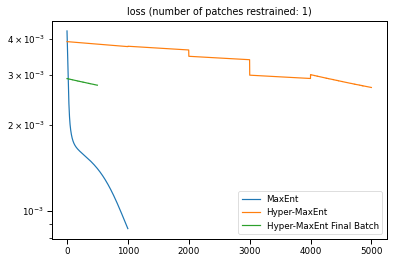

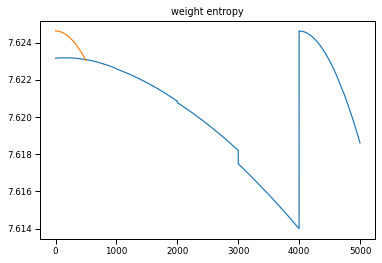

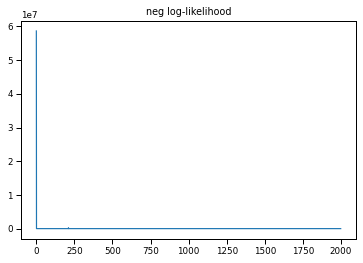

In [31]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

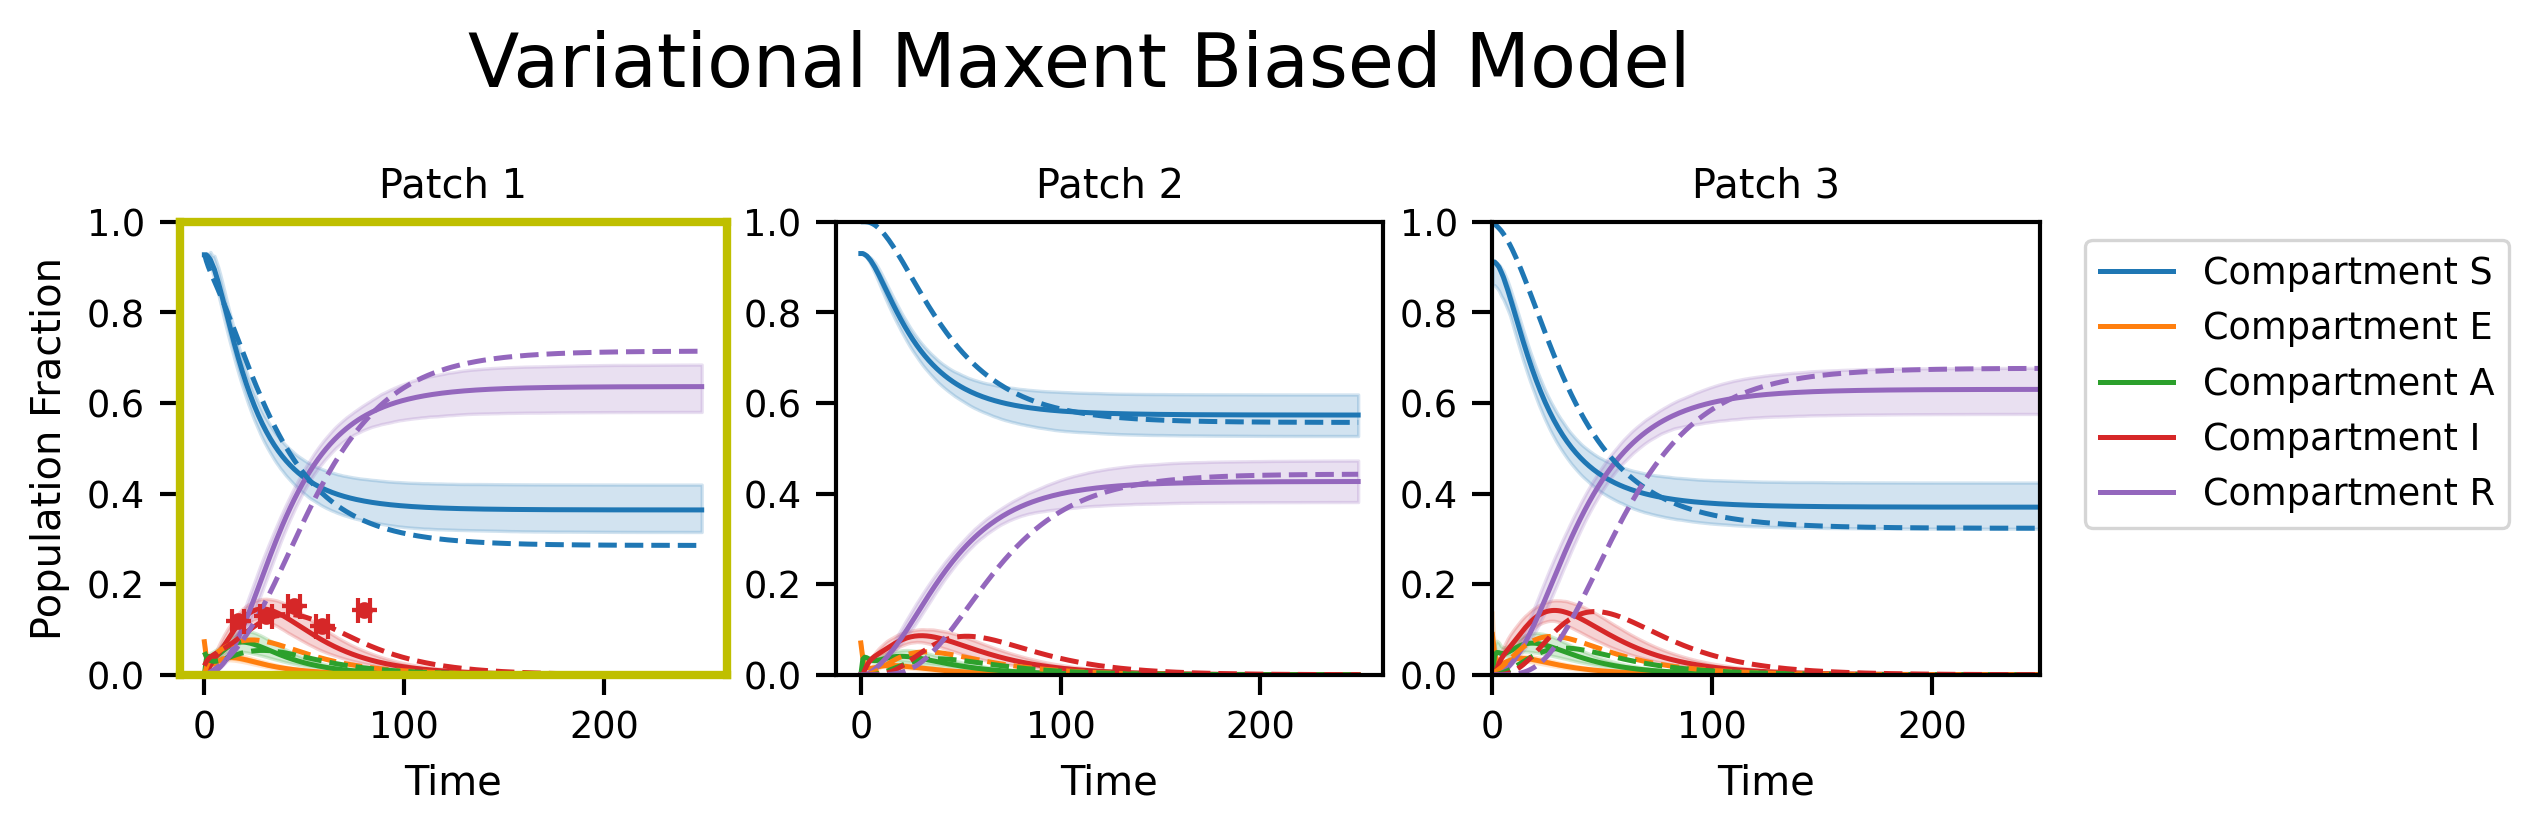

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Variational Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.savefig('varitional_maxent.svg', dpi=600)